In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import pandas as pd
import itertools
import matplotlib
import os
from Bio import SeqIO
from Bio import SeqUtils
import matplotlib.cm as cm
from ete3 import NCBITaxa
import re

In [2]:
def make_contig_df(contig_path, contig_name):
    """
    Make contig Dataframe from fasta file.
    """    
    f_handle = open(contig_path+'/'+contig_name, mode='r')
    contigs = SeqIO.parse(f_handle, 'fasta')
    contig_length = []
    contig_id =[]
    contig_GC = []
    assembly_id = []
    for x in contigs:
        contig_id.append(x.id)
        contig_length.append(len(x.seq))
        contig_GC.append(SeqUtils.GC(x.seq))
        assembly_id.append(p_and_a_ctg_file_name)
    s1 = pd.Series(contig_id, name='ID')
    s2 = pd.Series(contig_length, name='Length')
    s3 = pd.Series(contig_GC, name='%GC')
    s4 = pd.Series(assembly_id, name="Assembly")
    contig_df = pd.concat([s1, s2, s3, s4], axis=1)
    f_handle.close()
    return contig_df

In [3]:
#function to add another column for P and A_contig identification to dataframe
def P_and_A_identifier(df):
    """Method to add primary and alternative contig identifier rows to FC dataframes"""
    primary_list = []
    alternative_list = []
    return_df = df.iloc[:,:]
    for x in return_df['ID']:
        if "-" in list(x):
            primary_list.append(0)
            alternative_list.append(1)
        else:
            primary_list.append(1)
            alternative_list.append(0)
    return_df["P_contig"] = pd.Series(primary_list)
    return_df["A_contig"] = pd.Series(alternative_list)
    return_df = return_df.reset_index(drop=True)
    return return_df

In [4]:
#function that compares a seed with a result dataframe. It assesses if any initial IDs are missing from the result df
#and adds them with '0' in all columns to the result df
#ADD VALUE ERROR CHECK FOR EMPTY SEED_DF
def no_hit_df_extension(seed_df, result_df):
    """function that compares a seed with a result dataframe. 
    It assesses if any initial IDs are missing from the result df
    and adds them with '0' in all columns except the ID column.
    The first column in each dataframe needs to be labled 'ID'."""
    if len(list(set(seed_df.iloc[:,0])- set(result_df.iloc[:,0]))) == 0:
        #test if there actually missing values
        return pd.DataFrame()
    else:
        no_hit_sr = pd.Series(list(set(seed_df.iloc[:,0])- set(result_df.iloc[:,0])))
        #make empty dataframe for no_hits
        empty = np.array([[0]*(len(result_df.columns)-1) for x in range(len(no_hit_sr))])
        no_hit_df = pd.DataFrame(empty, columns =result_df.columns[1:])
        no_hit_df[result_df.columns.tolist()[0]] = no_hit_sr
        no_hit_df = no_hit_df[result_df.columns]
        return no_hit_df

In [5]:
def coverage_df_generator(file_path, file_name, seq_type):
    """
    Function that pulls in bed file coverage file. 
    It labels the header and calculates the average coverage per segment.
    """
    coverage_df = pd.read_csv(file_path+'/'+file_name, sep='\t', header=None)
    header_cov = ["ID-cov "+seq_type, "start "+seq_type, 'stop '+seq_type, "total hits "+seq_type]
    #rename the headear according bed file output
    rename = dict(zip(coverage_df.columns, header_cov))
    coverage_df.rename(columns=rename,inplace=True)
    #add another column for average coverage
    coverage_df["Average Coverage "+seq_type] = np.round(coverage_df['total hits '+seq_type]/(coverage_df['stop '+seq_type] -coverage_df['start '+seq_type]),3)
    coverage_df = coverage_df.sort_values(by=[coverage_df.columns.tolist()[0]]).reset_index(drop=True)
    return coverage_df
#no_hit_df_extension(p_and_a_ctg_df, blast_df)

In [6]:
def coverage_df_generator_all(file_path, file_name, seq_type, seed_df):
    """
    Function that pulls in bed file coverage file. 
    It labels the header and calculates the average coverage per segment.
    This also adds the IDs for which no hits have been reported.
    It returns a sorted df on the first ID column.
    """
    coverage_df = pd.read_csv(file_path+'/'+file_name, sep='\t', header=None)
    header_cov = ["ID-cov "+seq_type, "start "+seq_type, 'stop '+seq_type, "total hits "+seq_type]
    #rename the headear according bed file output
    rename = dict(zip(coverage_df.columns, header_cov))
    coverage_df.rename(columns=rename,inplace=True)
    #add another column for average coverage
    coverage_df["Average Coverage "+seq_type] = np.round(coverage_df['total hits '+seq_type]/(coverage_df['stop '+seq_type] -coverage_df['start '+seq_type]),3)
    #get no hit df, append and sort
    coverage_all_df = coverage_df.append(no_hit_df_extension(seed_df, coverage_df))
    coverage_all_df = coverage_all_df.sort_values(by=[coverage_all_df.columns.tolist()[0]]).reset_index(drop=True)
    return coverage_all_df
    #no_hit_df_extension(p_and_a_ctg_df, blast_df)

In [7]:
def add_cov_to_summary(sum_df, cov_df):
    """add coverage dataframe last "Average Coverage" column to blast summary df"""
    sum_sorted_df = sum_df.sort_values(by=[sum_df.columns.tolist()[0]]).reset_index(drop=True)
    cov_sorted_df = cov_df.sort_values(by=[cov_df.columns.tolist()[0]]).reset_index(drop=True)
    if set(sum_sorted_df.iloc[:,0] == cov_sorted_df.iloc[:,0]):
        sum_sorted_df[cov_sorted_df.columns.tolist()[-1]] = cov_sorted_df.iloc[:, -1]
        return sum_sorted_df
    else: #this should be made to raise an error
        print('Dataframes do not have the same ids')

In [180]:
def tc_blast_df(blast_xml_path, blast_xml_file_name, tc_list):
    """
    Returns a df of xml blast hits of target contigs.
    """
    from Bio.Blast import NCBIXML
    f = open(blast_xml_path+'/'+blast_xml_file_name, mode='r')
    blast_rec = NCBIXML.parse(f)
    tc_blast_df = pd.DataFrame()
    for record in blast_rec:
        if record.query.split(' ')[0] in tc_list: #the split may needs to be updated based on query blastn file headers.
                                                    #THINK long initial headers not _sh_ format
            NCBI_ID = []
            title_list = []
            query_contig = []
            sbj_start = []
            score_list =[]
            length=[]
            title = record.query.split(' ')[0]
            for aln in record.alignments:
                NCBI_ID.append('|'.join(aln.title.split('|')[0:4])+'|')
                title_list.append(aln.title.split('|')[4])
                query_contig.append(title)
                sbj_start_list = []
                query_score_list =[]
                length_list = []
                for hsp in aln.hsps:
                    sbj_start_list.append(hsp.query_start)
                    query_score_list.append(hsp.expect)
                    length_list.append(hsp.align_length)
                sbj_start.append(sbj_start_list)
                score_list.append(query_score_list)
                length.append(length_list)
            result_df = pd.concat([pd.Series(query_contig, name='ID'),pd.Series(NCBI_ID, name="ID-NCBI"), pd.Series(title_list, name='Blast Hit'), pd.Series(sbj_start, name='Contig Pos Aln'), pd.Series(length, name='Aln Length'), pd.Series(score_list, name='E-value')], axis =1)
            tc_blast_df = tc_blast_df.append(result_df)
    f.close()
    tc_blast_df = tc_blast_df.reset_index(drop=True)
    return tc_blast_df

In [1]:
def tc_blast_search_df(blast_xml_path, blast_xml_file_name, tc_list, search):
    """
    Returns a df of xml blast hits of target contigs were the query title matches the 'search' pattern.
    """
    from Bio.Blast import NCBIXML
    f = open(blast_xml_path+'/'+blast_xml_file_name, mode='r')
    blast_rec = NCBIXML.parse(f)
    tc_blast_df_2 = pd.DataFrame()
    for record in blast_rec:
        if record.query.split(' ')[0] in tc_list: #the split may needs to be updated based on query blastn file headers.                                            #THINK long initial headers not _sh_ format
            NCBI_ID = []
            title_list = []
            query_contig = []
            sbj_start = []
            score_list =[]
            length=[]
            title = record.query.split(' ')[0]
            #set the search term for your favorite blast hit
            for aln in record.alignments:
                #in case the title contains pattern match entered as search string in function
                if re.search(search, aln.title.split('|')[4]):
                    NCBI_ID.append('|'.join(aln.title.split('|')[0:4])+'|')
                    title_list.append(aln.title.split('|')[4])
                    query_contig.append(title)
                    sbj_start_list = []
                    query_score_list =[]
                    length_list = []
                    for hsp in aln.hsps:
                            sbj_start_list.append(hsp.query_start)
                            query_score_list.append(hsp.expect)
                            length_list.append(hsp.align_length)
                            sbj_start.append(sbj_start_list)
                            score_list.append(query_score_list)
                            length.append(length_list)
                result_df = pd.concat([pd.Series(query_contig, name='ID'),pd.Series(NCBI_ID, name="ID-NCBI"), pd.Series(title_list, name='Blast Hit'), pd.Series(sbj_start, name='Contig Pos Aln'), pd.Series(length, name='Aln Length'), pd.Series(score_list, name='E-value')], axis =1)
                tc_blast_df_2 = tc_blast_df_2.append(result_df)
    f.close()
    tc_blast_df_2 = tc_blast_df_2.reset_index(drop=True)
    return tc_blast_df_2

In [9]:
def print_first_5_blast_hits(blast_xml_df):
    """
    Does what is says in conjungtion with tc_blast_df.
    """
    #set count and read in first row
    count = 0
    previous = blast_xml_df.loc[0,'ID']
    #iterarte over each row and print the long blast_xml description until you reach #5
    for index,row in blast_xml_df.iterrows():
        if row['ID'] == previous:
            count += 1
            #print(count)
        if count < 6: 
            print(blast_xml_df.loc[index, 'ID'], '\t', blast_xml_df.loc[index, 'Blast Hit'])
        if row['ID'] != previous:
            count = 0
        previous = row['ID']

In [10]:
def print_all_blast_hits(blast_xml_df):
    """
    Does what is says in conjungtion with tc_blast_df.
    """
    #set count and read in first row
    count = 0
    previous = blast_xml_df.loc[0,'ID']
    #iterarte over each row and print all blast hits
    for index,row in blast_xml_df.iterrows():
        print(blast_xml_df.loc[index, 'ID'], '\t', blast_xml_df.loc[index, 'Blast Hit'])
        print("E-value",'\t', blast_xml_df.loc[index, 'E-value'])
        print("Contig Pos Aln",'\t', blast_xml_df.loc[index,'Contig Pos Aln'])


In [11]:
#here pull in intial unpolished query file from Falcon p_and_a_ctg and generate a dataframe
p_and_a_ctg_path ='/Users/ben/Documents/work_related/Canberra/RJ_lab_projects/Rust_genome_sequencing/PST79/analysis/PacBio_SCH1743/FALCON_0_4_assemblies/p_assemblies/v4_1/'
p_and_a_ctg_file_name = 'v4_1_p_and_a_ctg_sh.fa'
handle_1 = open(p_and_a_ctg_path+p_and_a_ctg_file_name)

In [12]:
#here enter your blast file you want to analyze in tabBS1 format
blast_tabBS1_path = '/Users/ben/Documents/work_related/Canberra/RJ_lab_projects/Rust_genome_sequencing/PST79/analysis/PacBio_SCH1743/FALCON_0_4_assemblies/p_assemblies/v4_1/blast/'
blast_tabBS1_handle = 'v4_1_p_and_a_sh.blast.local.tabBS1.nt'


In [13]:
#here enter your blast file you want to analyze in tabBS2 format
blast_tabBS2_path = '/Users/ben/Documents/work_related/Canberra/RJ_lab_projects/Rust_genome_sequencing/PST79/analysis/PacBio_SCH1743/FALCON_0_4_assemblies/p_assemblies/v4_1/blast/'
blast_tabBS2_handle = 'v4_1_p_and_a_sh.blast.local.tabBS2.nt'


In [14]:
#here enter in coverage files having the same IDs as seed file. This file has been produced by 'samtools bedcov'
cov_path='/Users/ben/Documents/work_related/Canberra/RJ_lab_projects/Rust_genome_sequencing/PST79/analysis/PacBio_SCH1743/FALCON_0_4_assemblies/p_assemblies/v4_1/Quiver/run_wo_useccs_22/coverage_analysis/LRM'
cov_file_name='v4_1_p_and_a_ctg_sh.q22.99999999999999.cov'
seq_type='PacBio'

In [15]:
#here enter the illumina cov file coresponding to p_and_a_ctg_path
cov_path_2='/Users/ben/Documents/work_related/Canberra/RJ_lab_projects/Rust_genome_sequencing/PST79/analysis/PacBio_SCH1743/FALCON_0_4_assemblies/p_assemblies/v4_1/Quiver/run_wo_useccs_22/coverage_analysis/SRM'
cov_file_name_2='v4_1_p_and_a_sh.folder_5_ete.sam.sorted.bam.99999999.cov'
seq_type_2='Illumina'

In [16]:
#here enter file name extension to xml blast file output
blast_xml_path = '/Users/ben/Documents/work_related/Canberra/RJ_lab_projects/Rust_genome_sequencing/PST79/analysis/PacBio_SCH1743/FALCON_0_4_assemblies/p_assemblies/v4_1/blast'
blast_xml_file_name ='v4_1_p_and_a.blast.local.nt'

In [17]:
#make dataframe of initial query file p_and_a_ctg_df
contigs = SeqIO.parse(handle_1, 'fasta')
contig_length = []
contig_id =[]
contig_GC = []
assembly_id = []
for x in contigs:
    contig_id.append(x.id)
    contig_length.append(len(x.seq))
    contig_GC.append(SeqUtils.GC(x.seq))
    assembly_id.append(p_and_a_ctg_file_name)
s1 = pd.Series(contig_id, name='ID')
s2 = pd.Series(contig_length, name='Length')
s3 = pd.Series(contig_GC, name='%GC')
s4 = pd.Series(assembly_id, name="Assembly")
p_and_a_ctg_df = pd.concat([s1, s2, s3, s4], axis=1)
handle_1.close()

In [18]:
p_and_a_ctg_df = P_and_A_identifier(p_and_a_ctg_df)

In [19]:
#pull in blast tabBS1 file, and rename header according to tabBS1 format convention
blast_df = pd.read_csv(blast_tabBS1_path+blast_tabBS1_handle, sep='\t', header=None)
header = ['ID', 'sseqid', 'evalue', 'bitscore', 'sgi', 'sacc', 'staxids', 'sscinames', 'scomnames', 'skingdoms']
rename = dict(zip(blast_df.columns, header))
blast_df.rename(columns=rename,inplace=True)

In [20]:
#pull in blast tabBS2 file, and rename header according to tabBS2 format convention
blast_df_2 = pd.read_csv(blast_tabBS2_path+blast_tabBS2_handle, sep='\t', header=None)
header_2 = ['ID', 'sseqid', 'evalue', 'bitscore', 'qstart', 'qend', 'length', 'sgi', 'sacc', 'staxids', 'sscinames', 'scomnames', 'skingdoms']
rename_2 = dict(zip(blast_df_2.columns, header_2))
blast_df_2.rename(columns=rename_2,inplace=True)
#sort the dataframe by "ID", "qstart", "bitscore"
blast_df_2 = blast_df_2.sort_values(by=["ID",'qstart','bitscore'], ascending=False).reset_index(drop=True)
#drop everything that is identical on the start position
blast_df_2 = blast_df_2.drop_duplicates(subset=["ID", "qstart"], keep='first').reset_index(drop=True)

In [21]:
#transform the TaxiD into a kingdom (or closest possible identifier) and add this to the blast_df as 'Kingdom' column
#THIS MIGHT WANT TO BECOME A FUNCTION IN THE NEAR FUTURE
ncbi=  NCBITaxa()
kingdom_list = []
for x in blast_df['staxids']:
    if ";" in list(x): #addresses the issue if one blast hit has multiple taxids
        x1 = x.split(";")[0]
        taxid_lineage = ncbi.get_lineage(x1)
    else:
        taxid_lineage = ncbi.get_lineage(x)
    if len(taxid_lineage) < 5: #addresses the issue if their is no kingdom id. simply pick the next up
        kingdom = ncbi.get_taxid_translator([taxid_lineage[-1]])
    else:
        kingdom = ncbi.get_taxid_translator([taxid_lineage[4]])
    kingdom_list.append(kingdom[list(kingdom)[0]])
blast_df['Kingdom'] = pd.Series(kingdom_list)

In [22]:
#transform the TaxiD into a kingdom (or closest possible identifier) and add this to the blast_df as 'Kingdom' column
#THIS MIGHT WANT TO BECOME A FUNCTION IN THE NEAR FUTURE
ncbi=  NCBITaxa()
kingdom_list = []
for x in blast_df_2['staxids']:
    if ";" in list(x): #addresses the issue if one blast hit has multiple taxids
        x1 = x.split(";")[0]
        taxid_lineage = ncbi.get_lineage(x1)
    else:
        taxid_lineage = ncbi.get_lineage(x)
    if len(taxid_lineage) < 5: #addresses the issue if their is no kingdom id. simply pick the next up
        kingdom = ncbi.get_taxid_translator([taxid_lineage[-1]])
    else:
        kingdom = ncbi.get_taxid_translator([taxid_lineage[4]])
    kingdom_list.append(kingdom[list(kingdom)[0]])
blast_df_2['Kingdom'] = pd.Series(kingdom_list)

In [23]:
#transform the TaxiD into a Superkingdom (or closest possible identifier) and add this to the blast_df as 'sKingdom' column
#THIS MIGHT WANT TO BECOME A FUNCTION IN THE NEAR FUTURE
kingdom_list = []
for x in blast_df['staxids']:
    if ";" in list(x): #addresses the issue if one blast hit has multiple taxids
        x1 = x.split(";")[0]
        taxid_lineage = ncbi.get_lineage(x1)
    else:
        taxid_lineage = ncbi.get_lineage(x)
    if len(taxid_lineage) < 5: #addresses the issue if their is no kingdom id. simply pick the next up
        kingdom = ncbi.get_taxid_translator([taxid_lineage[-1]])
    else:
        kingdom = ncbi.get_taxid_translator([taxid_lineage[2]])
    kingdom_list.append(kingdom[list(kingdom)[0]])
blast_df['Superkingdom'] = pd.Series(kingdom_list)

In [24]:
#transform the TaxiD into a Superkingdom (or closest possible identifier) and add this to the blast_df as 'sKingdom' column
#THIS MIGHT WANT TO BECOME A FUNCTION IN THE NEAR FUTURE
kingdom_list = []
for x in blast_df_2['staxids']:
    if ";" in list(x): #addresses the issue if one blast hit has multiple taxids
        x1 = x.split(";")[0]
        taxid_lineage = ncbi.get_lineage(x1)
    else:
        taxid_lineage = ncbi.get_lineage(x)
    if len(taxid_lineage) < 5: #addresses the issue if their is no kingdom id. simply pick the next up
        kingdom = ncbi.get_taxid_translator([taxid_lineage[-1]])
    else:
        kingdom = ncbi.get_taxid_translator([taxid_lineage[2]])
    kingdom_list.append(kingdom[list(kingdom)[0]])
blast_df_2['Superkingdom'] = pd.Series(kingdom_list)

In [25]:
blast_df = P_and_A_identifier(blast_df)

In [26]:
no_blast_hit_df = no_hit_df_extension(p_and_a_ctg_df, blast_df)

In [27]:
#append original blast_df with empty dataframe, sort by ID. 
#check for correct length between p_and_a_ctg_df and blast_all_df
blast_all_df = blast_df.append(no_blast_hit_df)
blast_all_sorted_df  = blast_all_df.sort_values(by=['ID'])[list(no_blast_hit_df.columns)].reset_index(drop=True)
len(set(blast_all_df['ID'])) ==  len(p_and_a_ctg_df)

True

In [28]:
blast_df_2 = P_and_A_identifier(blast_df_2)

In [29]:
no_blast_hit_df_2 = no_hit_df_extension(p_and_a_ctg_df, blast_df_2)

In [30]:
#append original blast_df_2 with empty dataframe, sort by ID. 
#check for correct length between p_and_a_ctg_df and blast_all_df_2
blast_all_df_2 = blast_df_2.append(no_blast_hit_df_2)
blast_all_sorted_df_2  = blast_all_df_2.sort_values(by=['ID'])[list(no_blast_hit_df_2.columns)].reset_index(drop=True)
len(set(blast_all_df_2['ID'])) ==  len(p_and_a_ctg_df)

True

In [31]:
#get all Superkingdoms of the dataframe and all contigs
Kingdoms = list(set(blast_all_sorted_df['Kingdom']))
contigs = sorted(list(set(blast_all_sorted_df['ID'])))

In [32]:
#get all Superkingdoms of the dataframe and all contigs
Kingdoms_2 = list(set(blast_all_sorted_df_2['Kingdom']))
contigs_2 = sorted(list(set(blast_all_sorted_df_2['ID'])))

In [33]:
#remove the '0' Superkingdom that was artificially generated by the no_hit_df
del Kingdoms[Kingdoms.index(0)]

In [34]:
#remove the '0' Superkingdom that was artificially generated by the no_hit_df
del Kingdoms_2[Kingdoms_2.index(0)]

In [35]:
#create a df summarizing all blast hits for each contig at the Kingdom level
list_of_summary_series =[]
overall_count = 0
for king in Kingdoms:
    king_list = []
    ID_list = []
    for Series in blast_all_sorted_df.groupby('ID')['Kingdom']:
        for x in Series[1:]: #is the list of ['Kingdom'] for each 'ID'
            count = 0
            for hit in x:
                overall_count += 1
                if hit == king:
                    count += 1
            king_list.append(count)
            ID_list.append(Series[0])
    list_of_summary_series.append(pd.Series(king_list, name=king))
list_of_summary_series.append(pd.Series(ID_list,name='ID-King'))
blast_hit_summary_df = pd.concat(list_of_summary_series, axis=1)
#create a 'Total Blast Hits' column
blast_hit_summary_df['Total King Blast Hits'] = blast_hit_summary_df[blast_hit_summary_df.columns[0]]*0
for x in range(0, (len(Kingdoms))):
    blast_hit_summary_df['Total King Blast Hits'] = blast_hit_summary_df['Total King Blast Hits'] + blast_hit_summary_df[list(blast_hit_summary_df.columns)[x]]  
#create %Eukaryota columns
blast_hit_summary_df['%Fungi'] = np.round(blast_hit_summary_df['Fungi']/blast_hit_summary_df['Total King Blast Hits']*100, 2)
blast_hit_summary_df = blast_hit_summary_df.fillna(0)
#quick test if all went correct
len(blast_hit_summary_df['Total King Blast Hits'])- len(blast_all_sorted_df.groupby('ID')['Kingdom'])

0

In [36]:
#create a df summarizing all blast hits for each contig at the Kingdom level for reduced blast_df_2
list_of_summary_series =[]
overall_count = 0
for king in Kingdoms_2:
    king_list = []
    ID_list = []
    for Series in blast_all_sorted_df_2.groupby('ID')['Kingdom']:
        for x in Series[1:]: #is the list of ['Kingdom'] for each 'ID'
            count = 0
            for hit in x:
                overall_count += 1
                if hit == king:
                    count += 1
            king_list.append(count)
            ID_list.append(Series[0])
    list_of_summary_series.append(pd.Series(king_list, name=king))
list_of_summary_series.append(pd.Series(ID_list,name='ID-King'))
blast_hit_summary_df_2 = pd.concat(list_of_summary_series, axis=1)
#create a 'Total Blast Hits' column
blast_hit_summary_df_2['Total King Blast Hits'] = blast_hit_summary_df_2[blast_hit_summary_df_2.columns[0]]*0
for x in range(0, (len(Kingdoms_2))):
    blast_hit_summary_df_2['Total King Blast Hits'] = blast_hit_summary_df_2['Total King Blast Hits'] + blast_hit_summary_df_2[list(blast_hit_summary_df_2.columns)[x]]  
#create %Eukaryota columns
blast_hit_summary_df_2['%Fungi'] = np.round(blast_hit_summary_df_2['Fungi']/blast_hit_summary_df_2['Total King Blast Hits']*100, 2)
blast_hit_summary_df_2 = blast_hit_summary_df_2.fillna(0)
#quick test if all went correct
len(blast_hit_summary_df_2['Total King Blast Hits'])- len(blast_all_sorted_df_2.groupby('ID')['Kingdom'])

0

In [37]:
#get all Superkingdoms of the dataframe and all contigs
Superkingdoms = list(set(blast_all_sorted_df['Superkingdom']))
contigs = sorted(list(set(blast_all_sorted_df['ID'])))

In [38]:
#get all Superkingdoms of the dataframe and all contigs
Superkingdoms_2 = list(set(blast_all_sorted_df_2['Superkingdom']))
contigs_2 = sorted(list(set(blast_all_sorted_df_2['ID'])))

In [39]:
#remove the '0' Superkingdom that was artificially generated by the no_hit_df
del Superkingdoms_2[Superkingdoms_2.index(0)]

In [40]:
#remove the '0' Superkingdom that was artificially generated by the no_hit_df
del Superkingdoms[Superkingdoms.index(0)]

In [41]:
#create a df summarizing all blast hits for each contig at the Superkingdom level
list_of_summary_series =[]
overall_count = 0
for king in Superkingdoms_2:
    king_list = []
    ID_list = []
    for Series in blast_all_sorted_df_2.groupby('ID')['Superkingdom']:
        for x in Series[1:]: #is the list of ['Superkingdom'] for each 'ID'
            count = 0
            for hit in x:
                overall_count += 1
                if hit == king:
                    count += 1
            king_list.append(count)
            ID_list.append(Series[0])
    list_of_summary_series.append(pd.Series(king_list, name=king))
list_of_summary_series.append(pd.Series(ID_list,name='ID-blast'))
blast_hit_summary_SK_df_2 = pd.concat(list_of_summary_series, axis=1)
#create a 'Total Blast Hits' column
blast_hit_summary_SK_df_2['Total Blast Hits'] = blast_hit_summary_SK_df_2[blast_hit_summary_SK_df_2.columns[0]]*0
for x in range(0, (len(Superkingdoms_2))):
    blast_hit_summary_SK_df_2['Total Blast Hits'] = blast_hit_summary_SK_df_2['Total Blast Hits'] + blast_hit_summary_SK_df_2[list(blast_hit_summary_SK_df_2.columns)[x]]  
#create %Eukaryota columns
blast_hit_summary_SK_df_2['%Eukaryota'] = np.round(blast_hit_summary_SK_df_2['Eukaryota']/blast_hit_summary_SK_df_2['Total Blast Hits']*100, 2)
blast_hit_summary_SK_df_2 = blast_hit_summary_SK_df_2.fillna(0)
#quick test if all went correct
len(blast_hit_summary_SK_df_2['Total Blast Hits'])- len(blast_all_sorted_df_2.groupby('ID')['Superkingdom'])

0

In [42]:
#create a df summarizing all blast hits for each contig at the Superkingdom level
list_of_summary_series =[]
overall_count = 0
for king in Superkingdoms:
    king_list = []
    ID_list = []
    for Series in blast_all_sorted_df.groupby('ID')['Superkingdom']:
        for x in Series[1:]: #is the list of ['Superkingdom'] for each 'ID'
            count = 0
            for hit in x:
                overall_count += 1
                if hit == king:
                    count += 1
            king_list.append(count)
            ID_list.append(Series[0])
    list_of_summary_series.append(pd.Series(king_list, name=king))
list_of_summary_series.append(pd.Series(ID_list,name='ID-blast'))
blast_hit_summary_SK_df = pd.concat(list_of_summary_series, axis=1)
#create a 'Total Blast Hits' column
blast_hit_summary_SK_df['Total Blast Hits'] = blast_hit_summary_SK_df[blast_hit_summary_SK_df.columns[0]]*0
for x in range(0, (len(Superkingdoms))):
    blast_hit_summary_SK_df['Total Blast Hits'] = blast_hit_summary_SK_df['Total Blast Hits'] + blast_hit_summary_SK_df[list(blast_hit_summary_SK_df.columns)[x]]  
#create %Eukaryota columns
blast_hit_summary_SK_df['%Eukaryota'] = np.round(blast_hit_summary_SK_df['Eukaryota']/blast_hit_summary_SK_df['Total Blast Hits']*100, 2)
blast_hit_summary_SK_df = blast_hit_summary_SK_df.fillna(0)
#quick test if all went correct
len(blast_hit_summary_SK_df['Total Blast Hits'])- len(blast_all_sorted_df.groupby('ID')['Superkingdom'])

0

In [43]:
p_and_a_ctg_sorted_df = p_and_a_ctg_df.sort_values(by='ID').reset_index(drop=True)

In [44]:
#add the summary_df to the seed_df
p_and_a_ctg_blast_df = pd.concat([p_and_a_ctg_sorted_df, blast_hit_summary_df.sort_values(by='ID-King')], axis =1)
p_and_a_ctg_blast_df = pd.concat([p_and_a_ctg_blast_df, blast_hit_summary_SK_df.sort_values(by='ID-blast')], axis =1)

In [45]:
#add the summary_df to the seed_df
p_and_a_ctg_blast_df_2 = pd.concat([p_and_a_ctg_sorted_df, blast_hit_summary_df_2.sort_values(by='ID-King')], axis =1)
p_and_a_ctg_blast_df_2 = pd.concat([p_and_a_ctg_blast_df_2, blast_hit_summary_SK_df_2.sort_values(by='ID-blast')], axis =1)

In [46]:
#quick test if all went alright
set(p_and_a_ctg_blast_df.loc[:,'ID'] == p_and_a_ctg_blast_df.loc[:,'ID-blast'])
#p_and_a_ctg_blast_df[p_and_a_ctg_blast_df['Total Blast Hits'] == 0].count()

{True}

In [47]:
#delete the 'ID-blast' column
del p_and_a_ctg_blast_df['ID-blast']

In [48]:
#add another column to the data frame that IDs the primary associated contig
primary_ID = []
for x in p_and_a_ctg_blast_df_2['ID']:
    if "-" in list(x):
        primary_ID.append(x[0:7])
    else:
        primary_ID.append(x)
p_and_a_ctg_blast_df_2["P_ID"] = pd.Series(primary_ID)

In [49]:
#add another column to the data frame that IDs the primary associated contig
primary_ID = []
for x in p_and_a_ctg_blast_df['ID']:
    if "-" in list(x):
        primary_ID.append(x[0:7])
    else:
        primary_ID.append(x)
p_and_a_ctg_blast_df["P_ID"] = pd.Series(primary_ID)

In [50]:
#safe the reduced blastdf #2 in cwd
p_and_a_ctg_blast_df_2.to_csv(blast_tabBS1_handle+'.blast_summary_reduced.csv', sep='\t', encoding='utf-8')

In [51]:
#safe the dataframe in cwd
p_and_a_ctg_blast_df.to_csv(blast_tabBS1_handle+'.blast_summary.csv', sep='\t', encoding='utf-8')

In [52]:
#append original cov_ with empty dataframe, sort by ID. 
#check for correct length between p_and_a_ctg_df and blast_all_df
cov_all_df = coverage_df_generator_all(cov_path, cov_file_name, 'PacBio', p_and_a_ctg_df)
cov_all_sorted_df  = cov_all_df.sort_values(by=[cov_all_df.columns.tolist()[0]]).reset_index(drop=True)
len(set(cov_all_sorted_df.iloc[:,0])) ==  len(p_and_a_ctg_df)

True

In [53]:
#add the PacBio coverage to the p_and_a_ctg_bast_df
p_and_a_ctg_blast_cov_df = add_cov_to_summary(p_and_a_ctg_blast_df, cov_all_sorted_df)

In [54]:
#add the PacBio coverage to the p_and_a_ctg_bast_df
p_and_a_ctg_blast_cov_df_2 = add_cov_to_summary(p_and_a_ctg_blast_df_2, cov_all_sorted_df)

In [55]:
#add the Illumina coverage
cov_contig_illumina = coverage_df_generator_all(cov_path_2, cov_file_name_2, seq_type_2, p_and_a_ctg_df)
p_and_a_ctg_blast_cov_df = add_cov_to_summary(p_and_a_ctg_blast_cov_df, cov_contig_illumina)

In [56]:
#add the Illumina coverage
cov_contig_illumina = coverage_df_generator_all(cov_path_2, cov_file_name_2, seq_type_2, p_and_a_ctg_df)
p_and_a_ctg_blast_cov_df_2 = add_cov_to_summary(p_and_a_ctg_blast_cov_df_2, cov_contig_illumina)

In [57]:
#safe the dataframe in cwd
p_and_a_ctg_blast_cov_df.to_csv(p_and_a_ctg_file_name+'.blast_cov_summary.csv', sep='\t', encoding='utf-8')

In [58]:
#safe the dataframe in cwd
p_and_a_ctg_blast_cov_df_2.to_csv(p_and_a_ctg_file_name+'.blast_cov_summary_reduced.csv', sep='\t', encoding='utf-8')

In [59]:
#example for getting blast results of interesting contigs
Eu_smaller_70_list = p_and_a_ctg_blast_cov_df[(p_and_a_ctg_blast_cov_df['%Eukaryota']<70)]['ID'].tolist()
Eu_smaller_70_blast_df = tc_blast_df(blast_xml_path, blast_xml_file_name, Eu_smaller_70_list)

In [60]:
#example to print the first 5 blast hits of each of those interesting contigs
print_first_5_blast_hits(Eu_smaller_70_blast_df)

000200F 	  Phakopsora pachyrhizi clone JGIAFNA-73C6, complete sequence
000200F 	  Melampsora larici-populina 98AG31 hypothetical protein (MELLADRAFT_48126), partial mRNA
000200F 	  Myroides odoratimimus strain PR63039, complete genome
000200F 	  Nonlabens dokdonensis DSW-6, complete genome
000200F 	  Lichtheimia ramosa genome assembly Lramosa_hybrid_454_Illumina, scaffold SCAF2
000006F-001-01 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 nonsense-mediated mRNA decay protein 3 (PGTG_16280), mRNA
000006F-001-01 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 nonsense-mediated mRNA decay protein 3 (PGTG_03805), mRNA
000006F-001-01 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein, variant (PGTG_15611), mRNA
000006F-001-01 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_15611), mRNA
000006F-001-01 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 ATP synthase subunit alpha, mitochondrial (PGTG_15605), mRNA
000006F-001-01 	  

(0, 60)

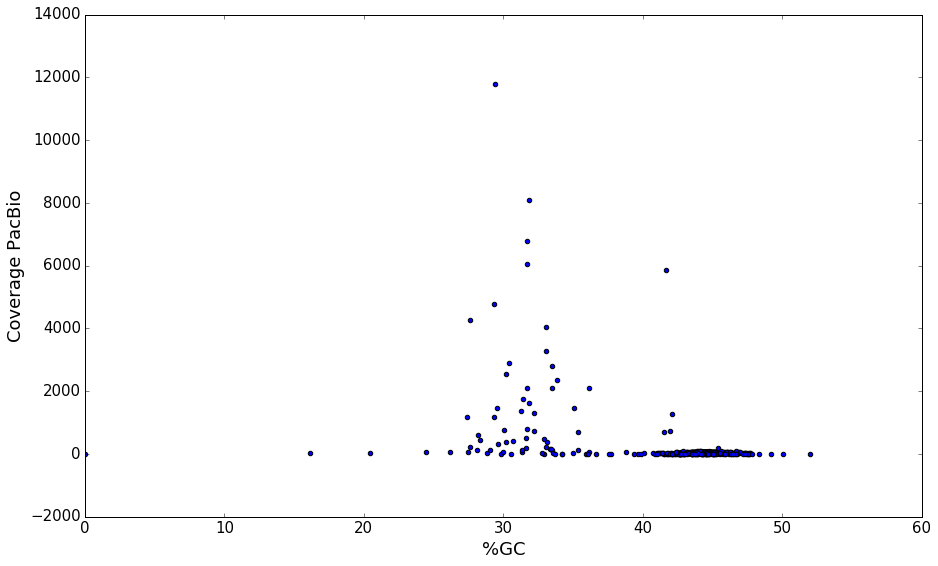

In [61]:
#some plotting examples
#e.g. %GC vs Average Coverage
plt.figure(figsize=(15,9))
plt.scatter(x=p_and_a_ctg_blast_cov_df['%GC'], y=p_and_a_ctg_blast_cov_df['Average Coverage PacBio'])
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font) #changes font of the plot
label_config_x = {'fontsize'            : 'large',
      'verticalalignment'   : 'top',
      'horizontalalignment' : 'center'
      }
label_config_y = {'fontsize'            : 'large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'
      }
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
plt.xlabel("%GC", **label_config_x)
plt.ylabel('Coverage PacBio', **label_config_y)

plt.xlim(0,60)

(0, 60)

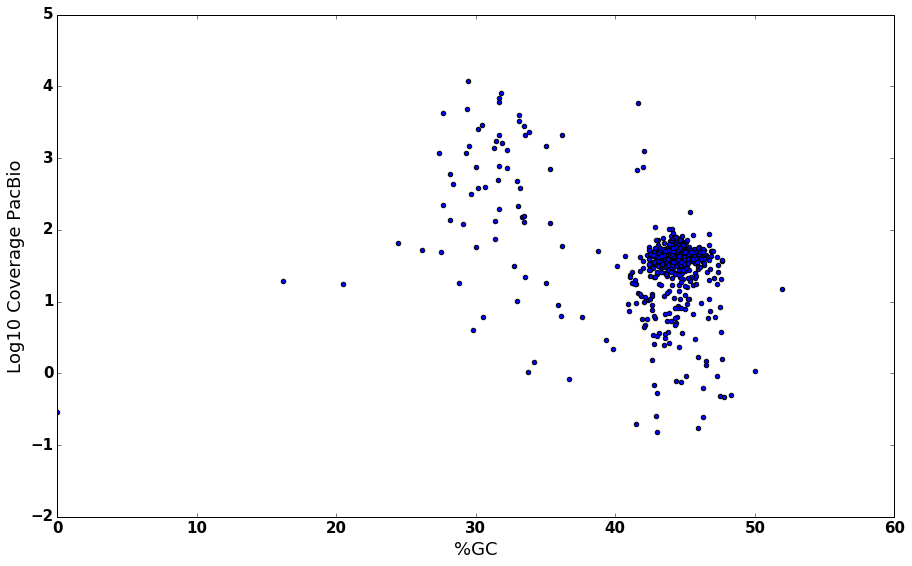

In [115]:
#some plotting examples
#e.g. %GC vs Average Coverage
plt.figure(figsize=(15,9))
plt.scatter(x=p_and_a_ctg_blast_cov_df['%GC'], y=np.log10(p_and_a_ctg_blast_cov_df['Average Coverage PacBio']))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font) #changes font of the plot
label_config_x = {'fontsize'            : 'large',
      'verticalalignment'   : 'top',
      'horizontalalignment' : 'center'
      }
label_config_y = {'fontsize'            : 'large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'
      }
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
plt.xlabel("%GC", **label_config_x)
plt.ylabel('Log10 Coverage PacBio', **label_config_y)

plt.xlim(0,60)

(-100, 14000)

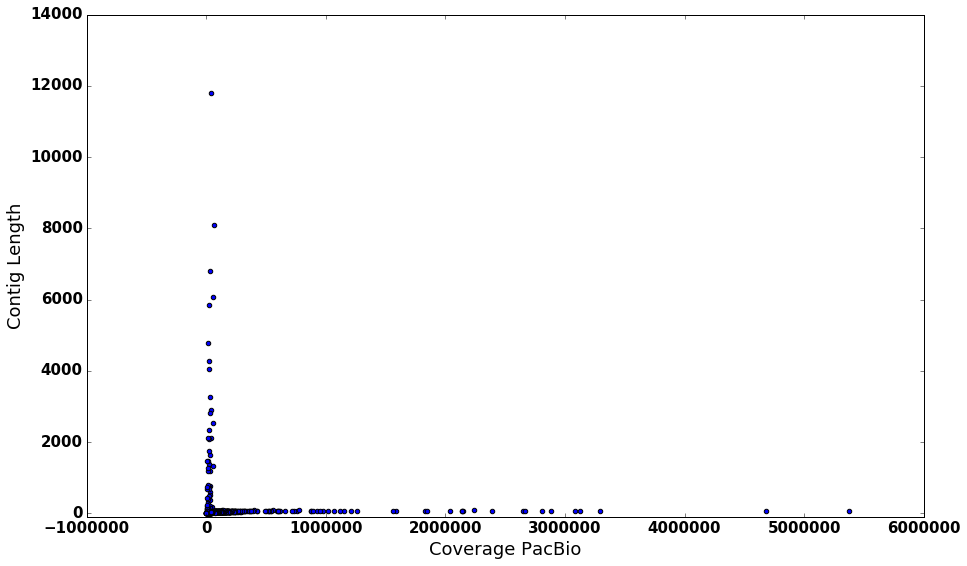

In [117]:
#contig_length vs Coverage
plt.figure(figsize=(15,9))
plt.scatter(y=p_and_a_ctg_blast_cov_df['Average Coverage PacBio'], x=p_and_a_ctg_blast_cov_df['Length'])
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font) #changes font of the plot
label_config_x = {'fontsize'            : 'large',
      'verticalalignment'   : 'top',
      'horizontalalignment' : 'center'
      }
label_config_y = {'fontsize'            : 'large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'
      }
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
plt.xlabel("Coverage PacBio", **label_config_x)
plt.ylabel('Contig Length', **label_config_y)
#plt.xlim(-10,400)
plt.ylim(-100,14000)

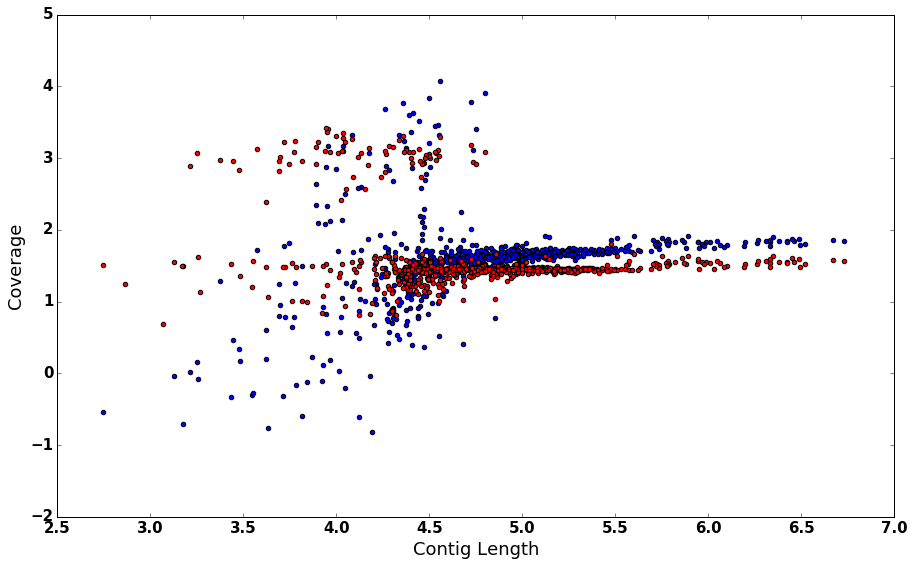

In [127]:
#contig_length vs Coverage
plt.figure(figsize=(15,9))
plt.scatter(y=np.log10(p_and_a_ctg_blast_cov_df['Average Coverage PacBio']), x=np.log10(p_and_a_ctg_blast_cov_df['Length']))
plt.scatter(y=np.log10(p_and_a_ctg_blast_cov_df['Average Coverage Illumina_all']), x=np.log10(p_and_a_ctg_blast_cov_df['Length']), c='r')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font) #changes font of the plot
label_config_x = {'fontsize'            : 'large',
      'verticalalignment'   : 'top',
      'horizontalalignment' : 'center'
      }
label_config_y = {'fontsize'            : 'large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'
      }
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
plt.xlabel("Contig Length", **label_config_x)
plt.ylabel('Coverage', **label_config_y)
#plt.xlim(-10,400)
#plt.ylim(-100,14000)

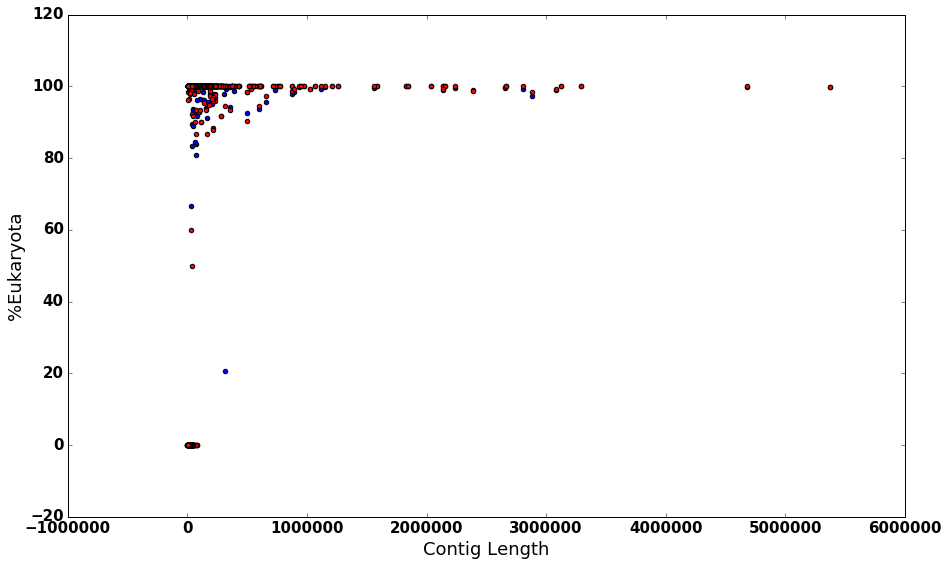

In [133]:
plt.figure(figsize=(15,9))
plt.scatter(x=p_and_a_ctg_blast_cov_df['Length'], y=p_and_a_ctg_blast_cov_df['%Eukaryota'])
plt.scatter(x=p_and_a_ctg_blast_cov_df_2['Length'], y=p_and_a_ctg_blast_cov_df_2['%Eukaryota'], c='r')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font) #changes font of the plot
label_config_x = {'fontsize'            : 'large',
      'verticalalignment'   : 'top',
      'horizontalalignment' : 'center'
      }
label_config_y = {'fontsize'            : 'large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'
      }
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
plt.xlabel("Contig Length", **label_config_x)
plt.ylabel('%Eukaryota', **label_config_y)
#plt.xlim(-10,400)
#plt.ylim(-100,1000000)

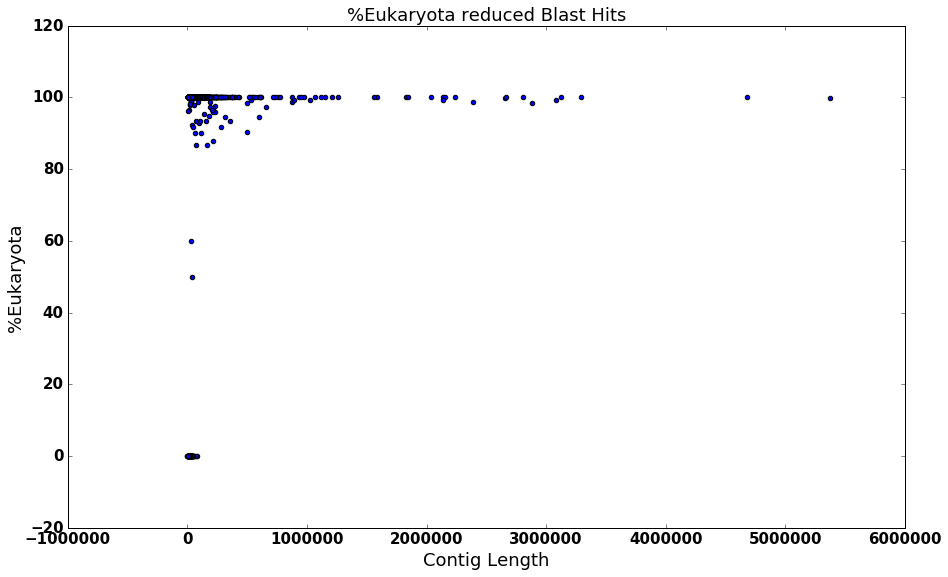

In [65]:
plt.figure(figsize=(15,9))
plt.scatter(x=p_and_a_ctg_blast_cov_df_2['Length'], y=p_and_a_ctg_blast_cov_df_2['%Eukaryota'])
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font) #changes font of the plot
label_config_x = {'fontsize'            : 'large',
      'verticalalignment'   : 'top',
      'horizontalalignment' : 'center'
      }
label_config_y = {'fontsize'            : 'large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'
      }
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
plt.xlabel("Contig Length", **label_config_x)
plt.ylabel('%Eukaryota', **label_config_y)
plt.title("%Eukaryota reduced Blast Hits")
#plt.xlim(-10,400)
#plt.ylim(-100,1000000)

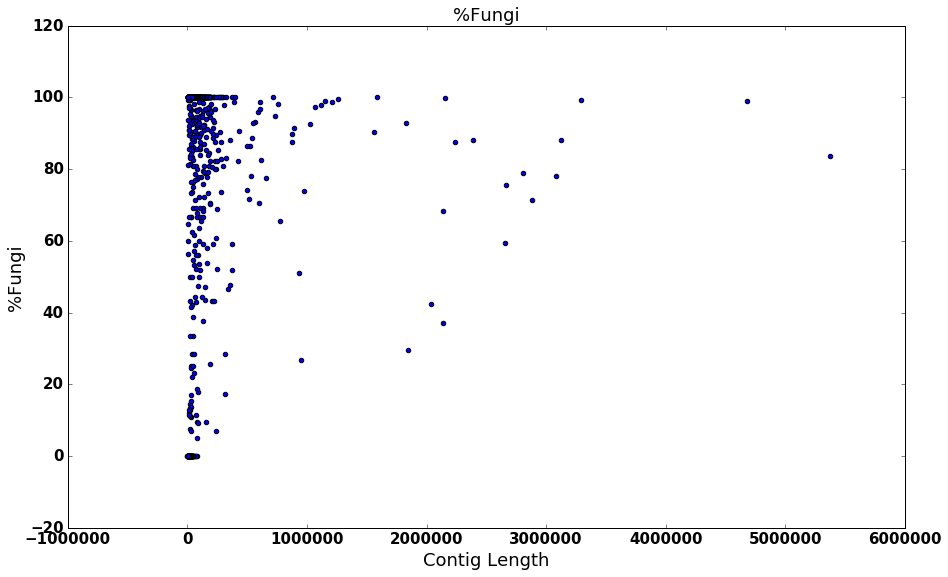

In [136]:
plt.figure(figsize=(15,9))
plt.scatter(x=p_and_a_ctg_blast_cov_df['Length'], y=p_and_a_ctg_blast_cov_df['%Fungi'])
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font) #changes font of the plot
label_config_x = {'fontsize'            : 'large',
      'verticalalignment'   : 'top',
      'horizontalalignment' : 'center'
      }
label_config_y = {'fontsize'            : 'large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'
      }
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
plt.xlabel("Contig Length", **label_config_x)
plt.ylabel('%Fungi', **label_config_y)
plt.title("%Fungi")
#plt.xlim(-10,400)
#plt.ylim(-100,1000000)

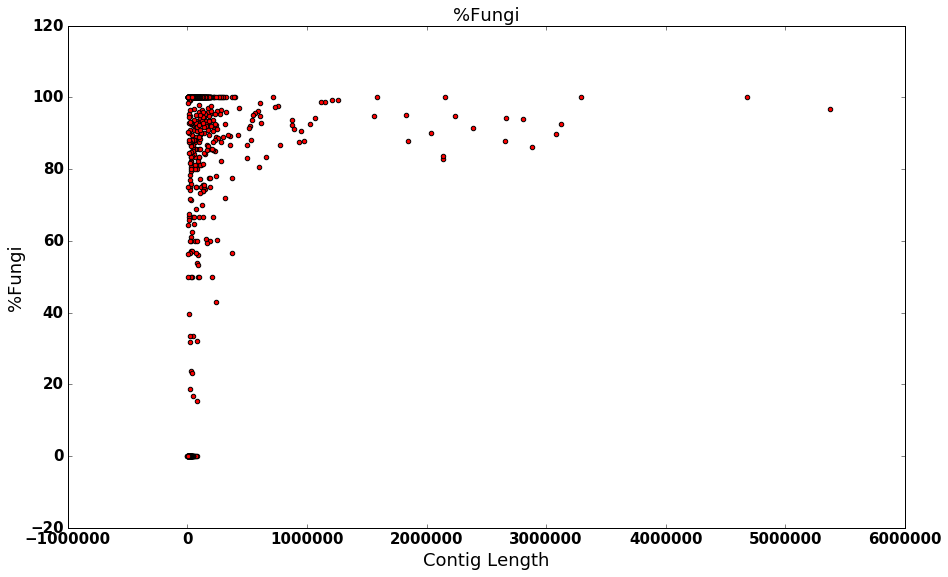

In [135]:
plt.figure(figsize=(15,9))
plt.scatter(x=p_and_a_ctg_blast_cov_df_2['Length'], y=p_and_a_ctg_blast_cov_df_2['%Fungi'], c='r')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font) #changes font of the plot
label_config_x = {'fontsize'            : 'large',
      'verticalalignment'   : 'top',
      'horizontalalignment' : 'center'
      }
label_config_y = {'fontsize'            : 'large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'
      }
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
plt.xlabel("Contig Length", **label_config_x)
plt.ylabel('%Fungi', **label_config_y)
plt.title("%Fungi")
#plt.xlim(-10,400)
#plt.ylim(-100,1000000)

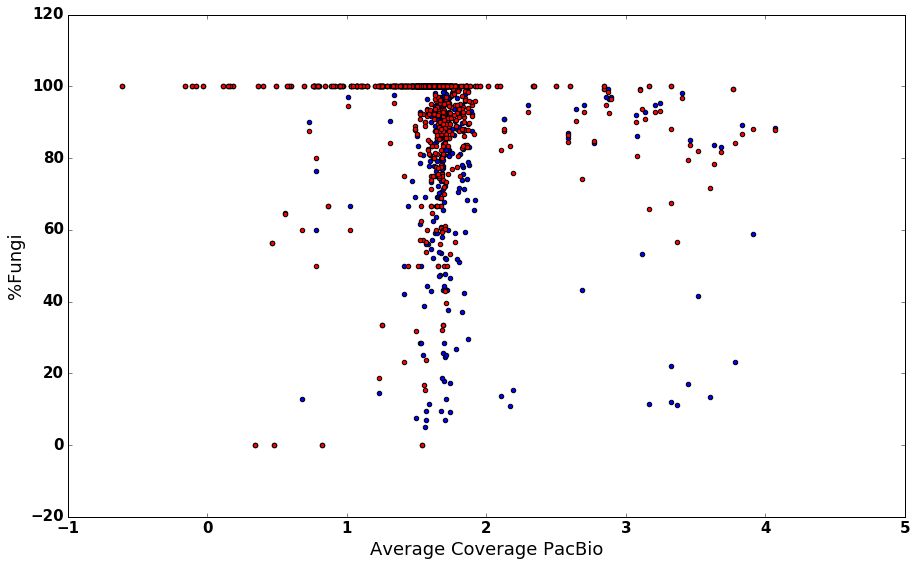

In [138]:
plt.figure(figsize=(15,9))
plt.scatter(x=np.log10(p_and_a_ctg_blast_cov_df[p_and_a_ctg_blast_cov_df['Total Blast Hits'] >0]['Average Coverage PacBio']), y=p_and_a_ctg_blast_cov_df[p_and_a_ctg_blast_cov_df['Total Blast Hits'] >0]['%Fungi'])
plt.scatter(x=np.log10(p_and_a_ctg_blast_cov_df_2[p_and_a_ctg_blast_cov_df_2['Total Blast Hits'] >0]['Average Coverage PacBio']), y=p_and_a_ctg_blast_cov_df_2[p_and_a_ctg_blast_cov_df_2['Total Blast Hits'] >0]['%Fungi'], c='r')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font) #changes font of the plot
label_config_x = {'fontsize'            : 'large',
      'verticalalignment'   : 'top',
      'horizontalalignment' : 'center'
      }
label_config_y = {'fontsize'            : 'large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'
      }
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
plt.xlabel("Average Coverage PacBio", **label_config_x)
plt.ylabel('%Fungi', **label_config_y)
#plt.xlim(-10,400)
#plt.ylim(-100,1000000)

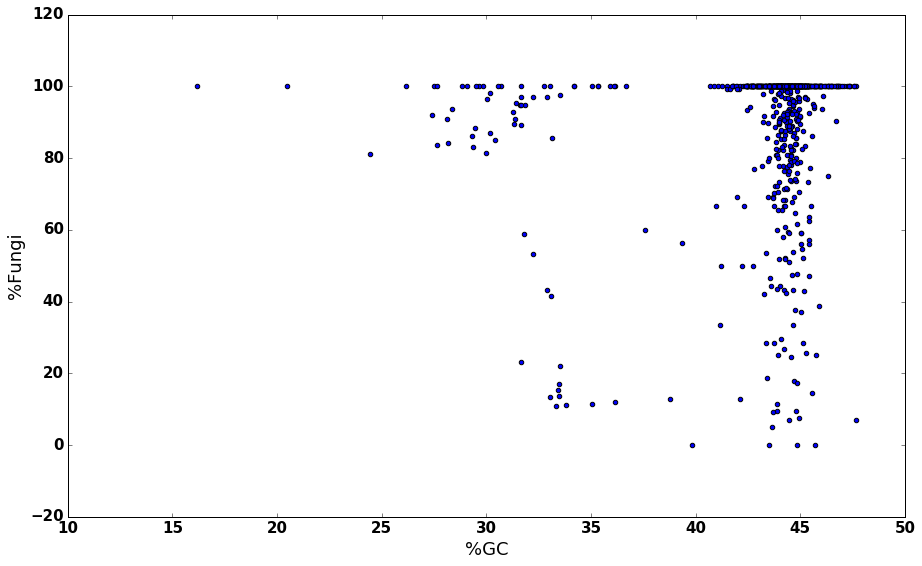

In [68]:
plt.figure(figsize=(15,9))
plt.scatter(x=(p_and_a_ctg_blast_cov_df[p_and_a_ctg_blast_cov_df['Total Blast Hits'] >0]['%GC']), y=p_and_a_ctg_blast_cov_df[p_and_a_ctg_blast_cov_df['Total Blast Hits'] >0]['%Fungi'])
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font) #changes font of the plot
label_config_x = {'fontsize'            : 'large',
      'verticalalignment'   : 'top',
      'horizontalalignment' : 'center'
      }
label_config_y = {'fontsize'            : 'large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'
      }
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
plt.xlabel("%GC", **label_config_x)
plt.ylabel('%Fungi', **label_config_y)
#plt.xlim(-10,400)
#plt.ylim(-100,1000000)

In [69]:
cov_contig_illumina = coverage_df_generator(cov_path_2, cov_file_name_2, seq_type_2)

In [70]:
cov_contig_illumina.head()

,ID-cov Illumina_all,start Illumina_all,stop Illumina_all,total hits Illumina_all,Average Coverage Illumina_all
0,000000F,0,5374253,198707533,36.974
1,000000F-001-01,0,89692,2882008,32.132
2,000000F-003-01,0,74018,2110303,28.511
3,000000F-004-01,0,77348,2485782,32.138
4,000000F-005-01,0,162191,4237904,26.129


In [71]:
p_and_a_ctg_blast_cov_df = add_cov_to_summary(p_and_a_ctg_blast_cov_df, cov_contig_illumina)

In [72]:
p_and_a_ctg_blast_cov_df.head()

,ID,Length,%GC,Assembly,P_contig,A_contig,Trimastix,uncultured prokaryote,Actinobacteria,Katablepharidaceae,...,Archaea,Eukaryota,synthetic construct,environmental samples,Bacteria,Total Blast Hits,%Eukaryota,P_ID,Average Coverage PacBio,Average Coverage Illumina_all
0,000000F,5374253,44.246261,v4_1_p_and_a_ctg_sh.fa,1,0,0,0,0,0,...,0,995,0,1,0,996,99.9,000000F,70.129,36.974
1,000000F-001-01,89692,43.236855,v4_1_p_and_a_ctg_sh.fa,0,1,0,0,0,0,...,0,3,0,0,0,3,100.0,000000F,40.630,32.132
2,000000F-003-01,74018,43.061147,v4_1_p_and_a_ctg_sh.fa,0,1,0,0,0,0,...,0,17,0,0,0,17,100.0,000000F,41.174,28.511
3,000000F-004-01,77348,42.430315,v4_1_p_and_a_ctg_sh.fa,0,1,0,0,0,0,...,0,17,0,0,0,17,100.0,000000F,58.217,32.138
4,000000F-005-01,162191,44.186176,v4_1_p_and_a_ctg_sh.fa,0,1,0,0,0,0,...,0,32,0,0,0,32,100.0,000000F,45.313,26.129


In [3]:
plt.figure(figsize=(15,9))
plt.scatter(x=p_and_a_ctg_blast_cov_df['Average Coverage PacBio'], y=p_and_a_ctg_blast_cov_df['Average Coverage Illumina_all'])
plt.ylabel("Illumina Coverage")
plt.xlabel("PacBio Coverage")
plt.xlim(-5,300)
plt.ylim(0,300)
plt.title("Illumina vs. PacBio Coverage")

NameError: name 'plt' is not defined

In [144]:
#overall number of contigs
p_and_a_ctg_blast_cov_df["ID"].count()

780

In [145]:
#number of contigs with <300 coverage for both
p_and_a_ctg_blast_cov_df[(p_and_a_ctg_blast_cov_df['Average Coverage PacBio'] < 300) & (p_and_a_ctg_blast_cov_df['Average Coverage Illumina_all'] < 300)]["ID"].count()

710

In [74]:
used_header = ["ID", "Length" ,"%GC", "%Fungi","%Eukaryota" ,"Total Blast Hits", "Average Coverage PacBio", "Average Coverage Illumina_all"]

In [75]:
low_coverage_PacBio = p_and_a_ctg_blast_cov_df[p_and_a_ctg_blast_cov_df['Average Coverage PacBio'] < 1].loc[:, used_header]

In [76]:
p_and_a_ctg_blast_cov_df['Average Coverage PacBio'].median()

43.888

In [77]:
!pwd

/Users/ben/Documents/work_related/Canberra/RJ_lab_projects/Rust_genome_sequencing/PST79/analysis/PacBio_SCH1743/FALCON_0_4_assemblies/p_assemblies/v4_1/blast


In [78]:
len(low_coverage_PacBio)

22

In [79]:
np.count_nonzero(low_coverage_PacBio['%Fungi'])

6

In [80]:
low_coverage_PacBio

,ID,Length,%GC,%Fungi,%Eukaryota,Total Blast Hits,Average Coverage PacBio,Average Coverage Illumina_all
33,000000F-042-01,1506,41.500664,0,0,0,0.198,31.174
191,000009F-002-01,734,37.738420,0,0,0,0.000,17.331
221,000011F-006-01,3530,48.300283,0,0,0,0.495,15.823
342,000025F-002-01,1852,42.602592,0,0,0,0.000,13.814
381,000033F,8330,44.345738,100,100,3,0.779,6.915
474,000059F,5749,39.676465,0,0,0,0.000,10.048
697,000263F,1164,34.192440,100,100,2,0.000,4.906
713,000279F,15540,42.985843,0,0,0,0.153,9.680
714,000280F,15145,45.084186,100,100,8,0.927,6.726
722,000288F,13232,46.319528,100,100,8,0.246,6.545


In [81]:
low_coverage_PacBio_blast_df = tc_blast_df(blast_xml_path ,blast_xml_file_name, low_coverage_PacBio["ID"].tolist())

In [82]:
print_first_5_blast_hits(low_coverage_PacBio_blast_df)

000033F 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_22598), mRNA
000033F 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_18266), mRNA
000033F 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_15358), mRNA
000263F 	  Puccinia cf. psidii AE-2014 cytochrome c oxidase subunit 1 (cox1) gene, complete cds; mitochondrial
000280F 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_17486), mRNA
000280F 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_02827), mRNA
000280F 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_02246), mRNA
000280F 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_11342), mRNA
000280F 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_21384), mRNA
000280F 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_03

In [83]:
below_50_Fungi = p_and_a_ctg_blast_cov_df[(p_and_a_ctg_blast_cov_df['%Fungi'] < 50)& (p_and_a_ctg_blast_cov_df['Total Blast Hits'] > 0)].loc[:, used_header]

In [84]:
below_50_Fungi_blast_df = tc_blast_df(blast_xml_path, blast_xml_file_name, below_50_Fungi["ID"].tolist())

In [85]:
print_first_5_blast_hits(tc_blast_df(blast_xml_path, blast_xml_file_name, below_50_Fungi["ID"].tolist()))

000011F 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_02544), mRNA
000011F 	  Puccinia striiformis f. sp. tritici strain CYR32 pik1 mRNA, complete cds
000011F 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_01590), mRNA
000011F 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 5-methyltetrahydropteroyltriglutamate-homocysteine methyltransferase (PGTG_02658), mRNA
000011F 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_19524), mRNA
000014F 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_08863), mRNA
000014F 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_13928), mRNA
000014F 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_04545), mRNA
000014F 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_19855), mRNA
000014F 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothet

In [86]:
below_20_Fungi = p_and_a_ctg_blast_cov_df[(p_and_a_ctg_blast_cov_df['%Fungi'] < 20) & (p_and_a_ctg_blast_cov_df['Total Blast Hits'] > 0)].loc[:, used_header]
below_10_Fungi = p_and_a_ctg_blast_cov_df[(p_and_a_ctg_blast_cov_df['%Fungi'] < 10) & (p_and_a_ctg_blast_cov_df['Total Blast Hits'] > 0)].loc[:, used_header]

In [87]:
below_10_Fungi_blast_df = tc_blast_df(blast_xml_path, blast_xml_file_name, below_10_Fungi["ID"].tolist())

In [88]:
below_10_Fungi

,ID,Length,%GC,%Fungi,%Eukaryota,Total Blast Hits,Average Coverage PacBio,Average Coverage Illumina_all
23,000000F-028-01,154476,43.903907,9.36,100,748,47.432,28.207
35,000001F-001-01,76356,44.811148,9.42,100,701,36.849,26.941
98,000003F-015-01,61366,44.850569,0.00,100,4,34.422,27.259
176,000008F-009-01,89903,43.689310,9.09,100,88,55.123,30.077
223,000011F-011-01,82074,43.638668,4.92,100,61,36.476,26.211
254,000013F-009-01,24878,44.935284,7.62,100,669,31.414,26.924
281,000016F-002-01,240423,44.464548,6.90,100,203,50.207,28.272
286,000016F-011-01,32032,47.677323,6.90,100,768,36.919,29.035
615,000182F,30990,43.530171,0.00,100,1,6.655,20.471
677,000244F,21689,45.719028,0.00,100,4,2.996,17.734


In [89]:
below_10_Fungi_blast_df

,ID,ID-NCBI,Blast Hit,Contig Pos Aln,Aln Length,E-value
0,000182F,gi|998501753|ref|XM_015655407.1|,PREDICTED: Neodiprion lecontei histone acetyl...,[16075],[216],[5.64941e-15]
1,000244F,gi|242055774|ref|XM_002456988.1|,"Sorghum bicolor hypothetical protein, mRNA","[14774, 9835]","[176, 176]","[3.05596e-16, 3.05596e-16]"
2,000244F,gi|193884876|gb|AC229909.1|,"Oryza minuta clone OM__Ba0163A13, complete se...","[14734, 9844]","[216, 216]","[3.07766e-11, 3.07766e-11]"
3,000335F,gi|952953202|gb|KT624874.1|,"Carteria crucifera clone contig5 chloroplast,...",[1544],[42],[5.45899e-06]
4,000335F,gi|673912155|gb|KJ845688.1|,Atractomorpha echinata strain UTEX 2309 cytoc...,[1545],[38],[5.45899e-06]
5,000000F-028-01,gi|403163213|ref|XM_003323269.2|,Puccinia graminis f. sp. tritici CRL 75-36-70...,"[130313, 131314]","[696, 298]","[3.84086e-157, 9.64565e-49]"
6,000000F-028-01,gi|403163218|ref|XM_003323275.2|,Puccinia graminis f. sp. tritici CRL 75-36-70...,[135308],[721],[5.07505e-141]
7,000000F-028-01,gi|403173240|ref|XM_003332281.2|,Puccinia graminis f. sp. tritici CRL 75-36-70...,"[78686, 78255]","[529, 364]","[3.32502e-78, 7.29996e-65]"
8,000000F-028-01,gi|403161843|ref|XM_003322106.2|,Puccinia graminis f. sp. tritici CRL 75-36-70...,[63764],[311],[2.00115e-75]
9,000000F-028-01,gi|403174616|ref|XM_003333520.2|,Puccinia graminis f. sp. tritici CRL 75-36-70...,[148917],[295],[2.02966e-65]


In [90]:
print_all_blast_hits(below_10_Fungi_blast_df)

000182F 	  PREDICTED: Neodiprion lecontei histone acetyltransferase Tip60 (LOC107217761), mRNA
E-value 	 [5.64941e-15]
Contig Pos Aln 	 [16075]
000244F 	  Sorghum bicolor hypothetical protein, mRNA
E-value 	 [3.05596e-16, 3.05596e-16]
Contig Pos Aln 	 [14774, 9835]
000244F 	  Oryza minuta clone OM__Ba0163A13, complete sequence
E-value 	 [3.07766e-11, 3.07766e-11]
Contig Pos Aln 	 [14734, 9844]
000335F 	  Carteria crucifera clone contig5 chloroplast, partial genome
E-value 	 [5.45899e-06]
Contig Pos Aln 	 [1544]
000335F 	  Atractomorpha echinata strain UTEX 2309 cytochrome c oxidase subunit 1 (cox1) gene, complete cds; mitochondrial
E-value 	 [5.45899e-06]
Contig Pos Aln 	 [1545]
000000F-028-01 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_04854), mRNA
E-value 	 [3.84086e-157, 9.64565e-49]
Contig Pos Aln 	 [130313, 131314]
000000F-028-01 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_04860), mRNA
E-value 	 [5.07505e-141]
C

In [91]:
below_50_Fungi

,ID,Length,%GC,%Fungi,%Eukaryota,Total Blast Hits,Average Coverage PacBio,Average Coverage Illumina_all
23,000000F-028-01,154476,43.903907,9.36,100.00,748,47.432,28.207
25,000000F-032-01,85221,44.683822,17.78,100.00,225,49.797,28.065
26,000000F-033-01,31056,45.739954,25.00,100.00,16,34.942,26.977
31,000000F-039-01,128184,44.738033,37.61,100.00,117,52.879,29.197
35,000001F-001-01,76356,44.811148,9.42,100.00,701,36.849,26.941
51,000001F-025-01,91545,44.605385,47.43,99.71,350,46.238,27.234
67,000002F-004-01,20463,45.579827,14.42,100.00,1484,17.096,28.455
74,000002F-012-01,188456,45.266269,25.68,99.18,366,48.832,28.725
75,000002F-013-01,357327,44.862549,47.62,99.84,609,50.446,28.661
85,000002F-024-01,147099,45.406155,47.02,100.00,151,45.970,28.794


In [92]:
contig_000067F = p_and_a_ctg_blast_cov_df[p_and_a_ctg_blast_cov_df['ID'] =='000067F']

In [93]:
contig_000067F_blast_df = tc_blast_df(blast_xml_path, blast_xml_file_name, contig_000067F["ID"].tolist())

In [94]:
print_all_blast_hits(contig_000067F_blast_df)

000067F 	  P.graminis (f.sp. tritici) actin DNA
E-value 	 [0.0]
Contig Pos Aln 	 [28007]
000067F 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 NADH-ubiquinone oxidoreductase 78 kDa subunit, mitochondrial (PGTG_06894), mRNA
E-value 	 [0.0]
Contig Pos Aln 	 [301265]
000067F 	  Puccinia striiformis f. sp. tritici strain CY32 actin mRNA, complete cds
E-value 	 [0.0, 0.0, 1.75468e-123, 8.45769e-97, 5.23632e-74, 5.54122e-34, 4.31404e-30, 3.40649e-16]
Contig Pos Aln 	 [27515, 28486, 28165, 28986, 29914, 29278, 28009, 29451]
000067F 	  Phakopsora pachyrhizi clone JGIAFNA-777M23, complete sequence
E-value 	 [4.70912e-149]
Contig Pos Aln 	 [28007]
000067F 	  Phakopsora pachyrhizi clone JGIAFNA-81H1, complete sequence
E-value 	 [4.70912e-149]
Contig Pos Aln 	 [28007]
000067F 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 actin (PGTG_05488), mRNA
E-value 	 [1.71783e-138, 4.01939e-80, 2.59638e-27, 3.43068e-11]
Contig Pos Aln 	 [28489, 28165, 29278, 29451]
000067F 	  Puccinia graminis f. 

In [95]:
Eu_smaller_70 = p_and_a_ctg_blast_cov_df[(p_and_a_ctg_blast_cov_df["%Eukaryota"] < 70) & (p_and_a_ctg_blast_cov_df['Total Blast Hits'] >0)].loc[:,used_header]

In [96]:
Eu_smaller_70

,ID,Length,%GC,%Fungi,%Eukaryota,Total Blast Hits,Average Coverage PacBio,Average Coverage Illumina_all
144,000006F-001-01,313752,44.831587,17.30,20.53,526,55.151,28.353
633,000200F,28528,42.316321,66.67,66.67,6,10.462,16.728


In [97]:
contig_000200F = p_and_a_ctg_blast_cov_df[p_and_a_ctg_blast_cov_df['ID'] =='000200F']

In [98]:
contig_000200F_blast_df = tc_blast_df(blast_xml_path, blast_xml_file_name, contig_000200F["ID"].tolist())

In [99]:
print_all_blast_hits(contig_000200F_blast_df)

000200F 	  Phakopsora pachyrhizi clone JGIAFNA-73C6, complete sequence
E-value 	 [3.02189e-37]
Contig Pos Aln 	 [17938]
000200F 	  Melampsora larici-populina 98AG31 hypothetical protein (MELLADRAFT_48126), partial mRNA
E-value 	 [2.36936e-28]
Contig Pos Aln 	 [20344]
000200F 	  Myroides odoratimimus strain PR63039, complete genome
E-value 	 [5.16517e-20]
Contig Pos Aln 	 [18301]
000200F 	  Nonlabens dokdonensis DSW-6, complete genome
E-value 	 [1.126e-11]
Contig Pos Aln 	 [18311]
000200F 	  Lichtheimia ramosa genome assembly Lramosa_hybrid_454_Illumina, scaffold SCAF2
E-value 	 [1.46691e-05, 1.46691e-05]
Contig Pos Aln 	 [20186, 20186]


In [100]:
contig_000006F_1_1 = p_and_a_ctg_blast_cov_df[p_and_a_ctg_blast_cov_df['ID'] =='000006F-001-01']

In [101]:
contig_000006F_1_1_blast_df = tc_blast_df(blast_xml_path, blast_xml_file_name, contig_000006F_1_1['ID'].tolist())

In [102]:
contig_000006F_1_1_blast_df.head()

,ID,ID-NCBI,Blast Hit,Contig Pos Aln,Aln Length,E-value
0,000006F-001-01,gi|403175647|ref|XM_003334363.2|,Puccinia graminis f. sp. tritici CRL 75-36-70...,[11498],[1291],[0.0]
1,000006F-001-01,gi|403161983|ref|XM_003322220.2|,Puccinia graminis f. sp. tritici CRL 75-36-70...,"[11498, 11121]","[1291, 284]","[0.0, 5.14637e-89]"
2,000006F-001-01,gi|403175209|ref|XM_003888988.1|,Puccinia graminis f. sp. tritici CRL 75-36-70...,"[270134, 268047]","[2119, 950]","[0.0, 2.76584e-166]"
3,000006F-001-01,gi|403175211|ref|XM_003334019.2|,Puccinia graminis f. sp. tritici CRL 75-36-70...,"[270134, 268047]","[2020, 950]","[0.0, 2.76584e-166]"
4,000006F-001-01,gi|403175205|ref|XM_003334013.2|,Puccinia graminis f. sp. tritici CRL 75-36-70...,"[261747, 261322, 260760, 261567, 261006, 262798]","[754, 168, 143, 116, 94, 88]","[0.0, 6.94591e-58, 2.55178e-42, 1.19566e-35, 9..."


In [103]:
#list of all blast ID-NCBI on the contig
ID_NCBI_000006F_1_1 = contig_000006F_1_1_blast_df['ID-NCBI'].tolist()

In [104]:
#pull out of the whole blast_df were these blast hits are to find on the assembly
contig_000006F_1_1_non_Eu = blast_df[(blast_df['sseqid'].apply(lambda x: x in ID_NCBI_000006F_1_1)) & (blast_df['skingdoms'] != 'Eukaryota')]

In [105]:
#only on one single contig pair
set(contig_000006F_1_1_non_Eu['ID'])

{'000006F', '000006F-001-01'}

In [106]:
non_Eu_start_map_list_000006F_1_1 =contig_000006F_1_1_blast_df[contig_000006F_1_1_blast_df['ID-NCBI'].apply(lambda x: x in contig_000006F_1_1_non_Eu['sseqid'].tolist())]['Contig Pos Aln'].tolist()

In [107]:
#identify the unique mapping sides on 000006F_1_1
target_side_list = {x for y in non_Eu_start_map_list_000006F_1_1 for x in itertools.chain(y) }
target_side_list

{261747, 262086, 262095, 262113}

In [108]:
non_Eu_start_map_list_000006F_1_1_df = contig_000006F_1_1_blast_df[contig_000006F_1_1_blast_df['ID-NCBI'].apply(lambda x: x in contig_000006F_1_1_non_Eu['sseqid'].tolist())]

In [109]:
non_Eu_start_map_list_000006F_1_1_df.head()

,ID,ID-NCBI,Blast Hit,Contig Pos Aln,Aln Length,E-value
33,000006F-001-01,gi|220956709|gb|FJ636639.1|,Synthetic construct Drosophila melanogaster c...,[261747],[756],[5.00278e-109]
34,000006F-001-01,gi|220947263|gb|FJ631916.1|,Synthetic construct Drosophila melanogaster c...,[261747],[756],[5.00278e-109]
84,000006F-001-01,gi|973752559|gb|CP013940.1|,"Cronobacter malonaticus LMG 23826, complete g...",[262086],[118],[1.57986e-19]
85,000006F-001-01,gi|564116047|gb|CP006731.1|,"Cronobacter sakazakii CMCC 45402, complete ge...",[262086],[118],[1.57986e-19]
87,000006F-001-01,gi|924308395|gb|CP012257.1|,"Cronobacter universalis NCTC 9529, complete g...",[262086],[118],[7.35036e-18]


In [110]:
blast_df[blast_df['sseqid'] ==  'gi|220956709|gb|FJ636639.1|']

,ID,sseqid,evalue,bitscore,sgi,sacc,staxids,sscinames,scomnames,skingdoms,Kingdom,Superkingdom,P_contig,A_contig
4035,000006F,gi|220956709|gb|FJ636639.1|,6.000000e-87,344,220956709,FJ636639,32630,synthetic construct,synthetic construct,NaN,synthetic construct,synthetic construct,1,0
57159,000006F-001-01,gi|220956709|gb|FJ636639.1|,5.000000e-109,414,220956709,FJ636639,32630,synthetic construct,synthetic construct,NaN,synthetic construct,synthetic construct,0,1


In [111]:
syn_construct_hits = blast_df[blast_df['sscinames'] ==  'synthetic construct']['sseqid'].tolist()

In [112]:
#maybe check those contigs
blast_df[blast_df['sscinames'] ==  'synthetic construct']['ID']

4035            000006F
4036            000006F
6487            000010F
20871           000019F
25600           000031F
30855           000064F
31684           000067F
43342           000232F
53011    000001F-030-01
55607    000002F-013-01
57090    000005F-019-01
57091    000005F-019-01
57092    000005F-019-01
57093    000005F-019-01
57094    000005F-019-01
57095    000005F-019-01
57159    000006F-001-01
57160    000006F-001-01
73227    000019F-013-01
Name: ID, dtype: object

In [151]:
#look for low %eukaryot hits
Eu_smaller_80_reduced = p_and_a_ctg_blast_cov_df_2[(p_and_a_ctg_blast_cov_df_2['%Eukaryota'] < 80) & (p_and_a_ctg_blast_cov_df_2['%Eukaryota'] > 0)]

In [152]:
Eu_smaller_80_reduced_df = tc_blast_df(blast_xml_path, blast_xml_file_name,Eu_smaller_80_reduced["ID"].tolist())

In [154]:
Eu_smaller_80_reduced_df

,ID,ID-NCBI,Blast Hit,Contig Pos Aln,Aln Length,E-value
0,000200F,gi|112181230|gb|AC188886.2|,"Phakopsora pachyrhizi clone JGIAFNA-73C6, com...",[17938],[243],[3.02189e-37]
1,000200F,gi|599384542|ref|XM_007409276.1|,Melampsora larici-populina 98AG31 hypothetica...,[20344],[122],[2.36936e-28]
2,000200F,gi|969868918|gb|CP013690.1|,"Myroides odoratimimus strain PR63039, complet...",[18301],[197],[5.16517e-20]
3,000200F,gi|442799322|gb|CP001397.1|,"Nonlabens dokdonensis DSW-6, complete genome",[18311],[182],[1.126e-11]
4,000200F,gi|671692496|emb|LK023324.1|,Lichtheimia ramosa genome assembly Lramosa_hy...,"[20186, 20186]","[76, 76]","[1.46691e-05, 1.46691e-05]"
5,000047F-007-01,gi|834774832|gb|CP011782.1|,Torulaspora delbrueckii strain NRRL Y-50541 c...,[16365],[94],[6.34503e-15]
6,000047F-007-01,gi|367014140|ref|XM_003681522.1|,Torulaspora delbrueckii hypothetical protein ...,[16365],[94],[2.95205e-13]
7,000047F-007-01,gi|359749124|emb|HE616746.1|,Torulaspora delbrueckii CBS 1146 chromosome 5...,[16365],[94],[2.95205e-13]
8,000047F-007-01,gi|574588616|gb|CP007067.1|,"Rhizobium leguminosarum bv. trifolii CB782, c...",[17343],[135],[1.77668e-10]
9,000047F-007-01,gi|998524942|ref|XM_015614336.1|,Debaryomyces fabryi Isocitrate dehydrogenase ...,[16365],[94],[2.97301e-08]


In [153]:
print_all_blast_hits(Eu_smaller_80_reduced_df)

000200F 	  Phakopsora pachyrhizi clone JGIAFNA-73C6, complete sequence
E-value 	 [3.02189e-37]
Contig Pos Aln 	 [17938]
000200F 	  Melampsora larici-populina 98AG31 hypothetical protein (MELLADRAFT_48126), partial mRNA
E-value 	 [2.36936e-28]
Contig Pos Aln 	 [20344]
000200F 	  Myroides odoratimimus strain PR63039, complete genome
E-value 	 [5.16517e-20]
Contig Pos Aln 	 [18301]
000200F 	  Nonlabens dokdonensis DSW-6, complete genome
E-value 	 [1.126e-11]
Contig Pos Aln 	 [18311]
000200F 	  Lichtheimia ramosa genome assembly Lramosa_hybrid_454_Illumina, scaffold SCAF2
E-value 	 [1.46691e-05, 1.46691e-05]
Contig Pos Aln 	 [20186, 20186]
000047F-007-01 	  Torulaspora delbrueckii strain NRRL Y-50541 chromosome 5 sequence
E-value 	 [6.34503e-15]
Contig Pos Aln 	 [16365]
000047F-007-01 	  Torulaspora delbrueckii hypothetical protein (TDEL0E01160) mRNA, complete cds
E-value 	 [2.95205e-13]
Contig Pos Aln 	 [16365]
000047F-007-01 	  Torulaspora delbrueckii CBS 1146 chromosome 5, complete geno

In [155]:
Eu_smaller_90_reduced = p_and_a_ctg_blast_cov_df_2[(p_and_a_ctg_blast_cov_df_2['%Eukaryota'] < 90) & (p_and_a_ctg_blast_cov_df_2['%Eukaryota'] > 0)]

In [156]:
Eu_smaller_90_reduced 

,ID,Length,%GC,Assembly,P_contig,A_contig,Actinobacteria,Nucleariidae and Fonticula group,Apusomonadidae,delta/epsilon subdivisions,...,Bacteria,Archaea,Eukaryota,environmental samples,ID-blast,Total Blast Hits,%Eukaryota,P_ID,Average Coverage PacBio,Average Coverage Illumina_all
236,000012F-005-01,167054,44.016905,v4_1_p_and_a_ctg_sh.fa,0,1,0,0,0,0,...,4,0,26,0,000012F-005-01,30,86.67,000012F,47.215,28.171
409,000040F-006-01,71413,45.431504,v4_1_p_and_a_ctg_sh.fa,0,1,1,0,0,1,...,4,0,26,0,000040F-006-01,30,86.67,000040F,36.670,28.326
437,000047F-007-01,34801,44.495848,v4_1_p_and_a_ctg_sh.fa,0,1,0,0,0,0,...,1,0,1,0,000047F-007-01,2,50.00,000047F,32.138,27.764
464,000055F-001-01,212140,45.021684,v4_1_p_and_a_ctg_sh.fa,0,1,3,1,0,1,...,7,0,50,0,000055F-001-01,57,87.72,000055F,44.527,28.241
633,000200F,28528,42.316321,v4_1_p_and_a_ctg_sh.fa,1,0,0,0,0,0,...,2,0,3,0,000200F,5,60.00,000200F,10.462,16.728


In [2]:
tc_blast_df_3 = tc_blast_search_df(blast_xml_path, blast_xml_file_name, p_and_a_ctg_df["ID"].tolist(), 'mitoch')

NameError: name 'blast_xml_path' is not defined

In [218]:
tc_blast_df_3.head()

,ID,ID-NCBI,Blast Hit,Contig Pos Aln,Aln Length,E-value
0,000000F,gi|253807586|gb|GQ338834.1|,"Phakopsora meibomiae mitochondrion, complete ...",[4097704],[124],[5.6879e-35]
1,000000F,gi|251765314|gb|GQ332420.1|,"Phakopsora pachyrhizi mitochondrion, complete...",[4097704],[124],[5.6879e-35]
2,000003F,gi|403178481|ref|XM_003336865.2|,Puccinia graminis f. sp. tritici CRL 75-36-70...,"[822435, 821542]","[322, 111]","[3.79617e-109, 1.17364e-34]"
3,000003F,gi|820845642|ref|XM_003693006.2|,PREDICTED: Apis florea probable NADH dehydrog...,"[822435, 821542]","[322, 111]","[3.79617e-109, 1.17364e-34]"
4,000003F,gi|572298467|ref|XM_006615322.1|,PREDICTED: Apis dorsata NADH dehydrogenase [u...,[346664],[292],[2.54049e-31]


In [213]:
len(tc_blast_df_2)

12979

In [217]:
len(tc_blast_df_3)

12979

In [176]:
High_PacBio_coverage_300 = p_and_a_ctg_blast_cov_df[p_and_a_ctg_blast_cov_df['Average Coverage PacBio'] > 300]

In [183]:
High_PacBio_coverage_300_df = tc_blast_df(blast_xml_path, blast_xml_file_name, High_PacBio_coverage_300["ID"].tolist())

In [187]:
print_first_5_blast_hits(High_PacBio_coverage_300_df)

000120F 	  Puccinia striiformis f. sp. tritici cytochrome b (cytb) gene, exons 1 through 3 and partial cds; mitochondrial
000120F 	  Puccinia graminis f. sp. tritici cytochrome b (cytb) gene, exons 1 through 3 and partial cds; mitochondrial
000120F 	  Puccinia coronata f. sp. avenae cytochrome b (cytb) gene, exons 1 through 3 and partial cds; mitochondrial
000120F 	  Puccinia hordei cytochrome b (cytb) gene, exons 1 through 3 and partial cds; mitochondrial
000120F 	  Puccinia recondita f. sp. secalis cytochrome b (cytb) gene, exons 1 through 3 and partial cds; mitochondrial
000127F 	  Puccinia graminis f. sp. tritici cytochrome b (cytb) gene, exons 1 through 3 and partial cds; mitochondrial
000127F 	  Puccinia coronata f. sp. avenae cytochrome b (cytb) gene, exons 1 through 3 and partial cds; mitochondrial
000127F 	  Puccinia hordei cytochrome b (cytb) gene, exons 1 through 3 and partial cds; mitochondrial
000127F 	  Puccinia recondita f. sp. secalis cytochrome b (cytb) gene, exons 1 t

In [178]:
High_PacBio_coverage_300["ID"].tolist()

['000120F',
 '000127F',
 '000131F',
 '000144F',
 '000156F',
 '000161F',
 '000165F',
 '000166F',
 '000168F',
 '000169F',
 '000170F',
 '000176F',
 '000177F',
 '000180F',
 '000183F',
 '000186F',
 '000187F',
 '000199F',
 '000206F',
 '000215F',
 '000218F',
 '000234F',
 '000235F',
 '000241F',
 '000245F',
 '000245F-001-01',
 '000250F',
 '000255F',
 '000266F',
 '000268F',
 '000281F',
 '000284F',
 '000289F',
 '000292F',
 '000296F',
 '000297F',
 '000305F',
 '000309F',
 '000315F']